# Language Detection using Tensorflow

In [ ]:
!pip install tensorflow pandas scikit-learn

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow as tf
from scipy.sparse import csr_matrix
import pickle

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

In [38]:
df = pd.read_csv('/content/Language Detection.csv')

# Let's do some EDA to be familiarize with the dataset

In [39]:
df.head(10)

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
5,"[2] In ancient philosophy, natura is mostly us...",English
6,"[3][4] \nThe concept of nature as a whole, the...",English
7,During the advent of modern scientific method ...,English
8,"[5][6] With the Industrial revolution, nature ...",English
9,"However, a vitalist vision of nature, closer t...",English


In [40]:
# Let's count the variations of our dataset
df["Language"].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: Language, dtype: int64

In [41]:
language_counts = df["Language"].value_counts().reset_index()
language_counts.columns = ["Language", "Count"]

# Display the new DataFrame
print(language_counts)

      Language  Count
0      English   1385
1       French   1014
2      Spanish    819
3   Portugeese    739
4      Italian    698
5      Russian    692
6     Sweedish    676
7    Malayalam    594
8        Dutch    546
9       Arabic    536
10     Turkish    474
11      German    470
12       Tamil    469
13      Danish    428
14     Kannada    369
15       Greek    365
16       Hindi     63


<ipython-input-42-b2f7f36fc496>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Language', data=language_counts, palette='muted')


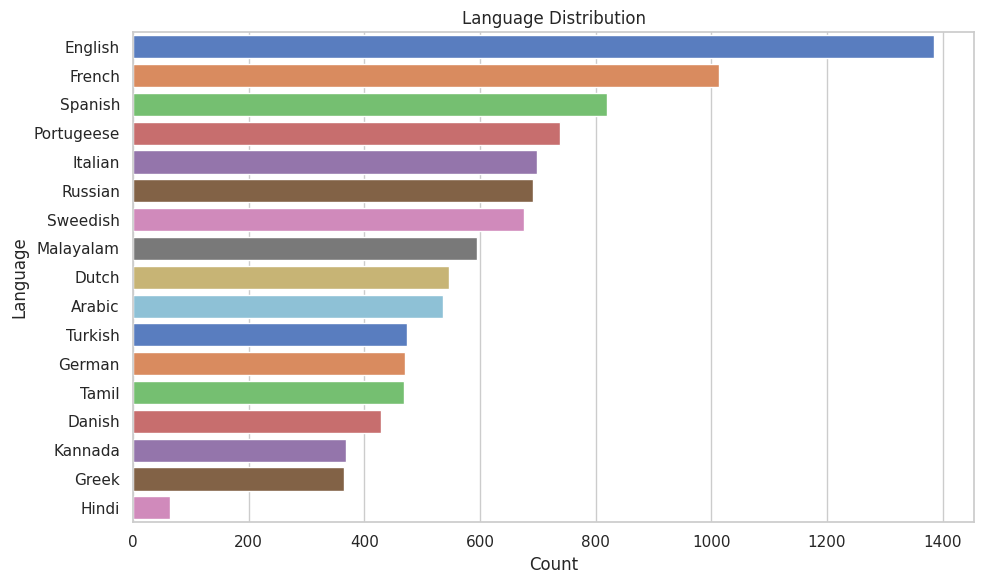

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Language', data=language_counts, palette='muted')
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Language Distribution')
plt.tight_layout()
plt.show()

# Let's start building the model now

In [43]:
# splitting the df to test and train data
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['Language'], test_size=0.2, random_state=42)

In [44]:
# Tokenize and vectorize the text data
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [45]:
# Encode the language labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

In [46]:
# Let's Build the model

model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])
#rectified linear unit (ReLU)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [47]:
# manually splitting the data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [48]:
# Convert sparse matrices to TensorFlow Sparse Tensors

X_train_sparse = tf.convert_to_tensor(csr_matrix(X_train).todense(), dtype=tf.float32)
X_val_sparse = tf.convert_to_tensor(csr_matrix(X_val).todense(), dtype=tf.float32)
X_test_sparse = tf.convert_to_tensor(csr_matrix(X_test).todense(), dtype=tf.float32)

In [49]:
# Let's train the model using the train data

history = model.fit(X_train_sparse, y_train, epochs=10, batch_size=32, validation_data=(X_val_sparse, y_val))

Epoch 1/10
207/207 [==============================] - 23s 108ms/step - loss: 0.9847 - accuracy: 0.8342 - val_loss: 0.2383 - val_accuracy: 0.9686
Epoch 2/10
207/207 [==============================] - 29s 140ms/step - loss: 0.1315 - accuracy: 0.9887 - val_loss: 0.1511 - val_accuracy: 0.9728
Epoch 3/10
207/207 [==============================] - 17s 81ms/step - loss: 0.0465 - accuracy: 0.9974 - val_loss: 0.1306 - val_accuracy: 0.9716
Epoch 4/10
207/207 [==============================] - 13s 64ms/step - loss: 0.0224 - accuracy: 0.9980 - val_loss: 0.1253 - val_accuracy: 0.9692
Epoch 5/10
207/207 [==============================] - 14s 66ms/step - loss: 0.0139 - accuracy: 0.9985 - val_loss: 0.1230 - val_accuracy: 0.9674
Epoch 6/10
207/207 [==============================] - 13s 62ms/step - loss: 0.0099 - accuracy: 0.9983 - val_loss: 0.1229 - val_accuracy: 0.9655
Epoch 7/10
207/207 [==============================] - 13s 62ms/step - loss: 0.0081 - accuracy: 0.9985 - val_loss: 0.1281 - val_accurac

# Let's evaluate the model

In [50]:
# Time to Evaluate the model

predictions = model.predict(X_test)
y_pred = predictions.argmax(axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

65/65 [==============================] - 0s 3ms/step
Test Accuracy: 95.65%


In [51]:
# Let's save the model file as a pkl file, using python pickle

with open('language_detection_model-0.0.1.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Let's review our model

In [52]:
import numpy as np

# Let's create a function to test the model out
def predict_language(input_text):
    # Preprocess input text
    input_text = [input_text]
    input_vector = vectorizer.transform(input_text)
    input_sparse = tf.convert_to_tensor(input_vector.todense(), dtype=tf.float32)

    # Make prediction using the trained model
    predictions = model.predict(input_sparse)

    # Convert predicted index back to language label
    predicted_label_index = np.argmax(predictions)
    predicted_language = label_encoder.classes_[predicted_label_index]

    return predicted_language


In [53]:
input_text = "Checking if this works"
predicted_language = predict_language(input_text)

print(f"The predicted language for '{input_text}' is: {predicted_language}")

1/1 [==============================] - 0s 134ms/step
The predicted language for 'Checking if this works' is: English


In [54]:
input_text = "namma bengaluru"
predicted_language = predict_language(input_text)

print(f"The predicted language for '{input_text}' is: {predicted_language}")

1/1 [==============================] - 0s 33ms/step
The predicted language for 'namma bengaluru' is: Kannada


In [55]:
input_text = "Wie geht es dir"
predicted_language = predict_language(input_text)

print(f"The predicted language for '{input_text}' is: {predicted_language}")

1/1 [==============================] - 0s 27ms/step
The predicted language for 'Wie geht es dir' is: German


In [56]:
input_text = "как жизнь"
predicted_language = predict_language(input_text)

print(f"The predicted language for '{input_text}' is: {predicted_language}")

1/1 [==============================] - 0s 25ms/step
The predicted language for 'как жизнь' is: Russian
